In [83]:
from qiskit.circuit import QuantumCircuit, Parameter
import numpy as np
phi = Parameter("1")
phi2 = Parameter("2")
qr = QuantumRegister(nr_of_qubits)
circuit = QuantumCircuit(qr)
circuit.h([0])
circuit.h([1])
circuit.h([2])
circuit.h([3])
circuit.rx(phi,qubit=[0])
circuit.rx(phi2,qubit=[1])
print(circuit)
print(circuit.parameters)
value = np.random.random()
parameters = [value for _ in range(2)]
print(circuit.bind_parameters(parameters))

       ┌───┐┌───────┐
q68_0: ┤ H ├┤ Rx(1) ├
       ├───┤├───────┤
q68_1: ┤ H ├┤ Rx(2) ├
       ├───┤└───────┘
q68_2: ┤ H ├─────────
       ├───┤         
q68_3: ┤ H ├─────────
       └───┘         
ParameterView([Parameter(1), Parameter(2)])
       ┌───┐┌───────────────────────┐
q68_0: ┤ H ├┤ Rx(0.349398938987163) ├
       ├───┤├───────────────────────┤
q68_1: ┤ H ├┤ Rx(0.349398938987163) ├
       ├───┤└───────────────────────┘
q68_2: ┤ H ├─────────────────────────
       ├───┤                         
q68_3: ┤ H ├─────────────────────────
       └───┘                         


In [23]:
individual = "0000000"
elitism_population = ["1110111","1111111"]
match_percentage = []
def match(subject_1,subject_2):
    return sum([int(subject_1[i] == subject_2[i]) for i in range(0,len(subject_1))])/len(subject_1)
for elite in elitism_population:
    match_percentage.append(match(individual,elite))
    print(match_percentage)
print(sum(match_percentage)/len(match_percentage))

[0.14285714285714285]
[0.14285714285714285, 0.0]
0.07142857142857142


In [266]:
from Experiments import saveLoad
from CLQGA import Individual
output = saveLoad("load","experiment_12_may_init_energy_mutation_0", None)
# print(len(output))
experiment_population = output[0]
experiment_duration = output[1]
experiment_average_fitness_50_increment = output[2]
experiment_average_crowd_score_50_increment = output[3]
experiment_average_error_rate_50_increment = output[4]
# # for the individual the structure is [fitness, error, chromosome, current generation, unconfigured circuit, configured circuit]
experiment_best_individual = output[5]
# # # for the family the structure is [average elitism fitness, average elitism error, current generation, family set of chromosomes]
experiment_best_family = output[6]
# # # for the evolution the structure is [[best individual number of operation, best individual number of controlled gates], [family average number of operations, family average number of controlled operations]]
experiment_evolution = output[7]
# # # # ising instance
ising_instance = output[8]
print(experiment_average_fitness_50_increment)

[16203.119876315739, 20223.982437953535, 24394.056629642713, 23244.23641785304, 25626.347540965922, 26893.85253888332, 38583.62974750296, 48900.27927278919, 41289.86260519963, 36034.96716775866]


In [267]:
from HelperCLQGA import compute_expected_energy, ising_1d_instance
import math
def bruteforceLowestValue(h,j):
    def bool_to_state(integer):
    # Convert the 1/0 of a bit to +1/-1
        return 2*int(integer)-1

    r1=list([f'{i:0{len(h)}b}' for i in range(2**len(h))])
    best_energy = math.inf

    for k in range(0,len(r1)):
        current_energy = 0
        # r2[k] is the number of shots that have this result
        # r1[k] is the result as qubits (like 0001)
        # Energy of h
        current_energy += sum([bool_to_state(r1[k][bit_value])*h[bit_value] for bit_value in range(0,len(r1[k]))])
        # Energy of j
        current_energy += sum([bool_to_state(r1[k][bit_value])*bool_to_state(r1[k][bit_value+1])*j[bit_value] for bit_value in range(0,len(j))])
        if current_energy < best_energy:
            best_energy = current_energy

    return best_energy

# observable_h, observable_j = ising_1d_instance(4, None)
observable_h = ising_instance[0]
observable_j = ising_instance[1]
print(observable_h, observable_j)
exact_classical_solution = bruteforceLowestValue(observable_h,observable_j)
print(exact_classical_solution)

[-1, -1, -1, 1] [-1, -1, -1]
-5


In [231]:
import numpy as np
import math
from HelperCLQGA import energy_from_circuit, genome_to_circuit
from qiskit_aer import AerSimulator
from scipy.optimize import minimize

backend_sim = AerSimulator()

delta_energy_saved = []
upper_bound = 0.001
lower_bound = 0

for individal in experiment_best_individual:
    ## if the object you are trying to evaluate has chromosomes use the next line
    # ind_ansatz,num_parameters = genome_to_circuit(individal.chromosome, 4, 20)
    ## if the object has a unconfigured circuit use the next lines!
    ind_ansatz = individal[4]
    num_parameters = individal[4].num_parameters
    parameters0 = [np.random.random()* (upper_bound-lower_bound)+lower_bound for _ in range(num_parameters)]
    def expectation_function(parameters):
        return energy_from_circuit(ind_ansatz.bind_parameters(parameters), ind_ansatz.num_qubits, observable_h, observable_j, 4000, backend_sim)
    vqe_result = minimize(expectation_function,parameters0, method="COBYLA", tol=1e-5, options={"maxiter":100**4})
    print(vqe_result.fun)
    delta_energy_saved.append(vqe_result.fun-exact_classical_solution)

def matching(array):
    matches = 0
    for i in range(len(array)):
        if array[i] < 0.0099:
            matches += 1
    return matches
# print("Percentage of circuits that are able to reach the ground state: {}%".format((matching(delta_energy_saved)/len(delta_energy_saved))*100))
print("Average delta energy in the population of benchmark 10 qubits: {} \nAverage delta energy in the elitism pool of benchmark 4 qubits: {}\nDelta energy of the best individual of benchmark 4 qubits: {}\nPercentage of circuits that are able to reach the ground state: {}%".format(sum(delta_energy_saved)/len(delta_energy_saved),sum(delta_energy_saved[:10])/len(delta_energy_saved[:10]),delta_energy_saved[0],(matching(delta_energy_saved)/len(delta_energy_saved))*100))

-4.011
-5.0
-4.983
-3.981
-4.356
-4.005
-3.991
-4.9985
-4.99
-5.0
-5.0
-5.0
-3.9695
-3.9515
-4.9975
-5.0
-5.0
-4.9995
Average delta energy in the population of benchmark 10 qubits: 0.3759166666666667 
Average delta energy in the elitism pool of benchmark 4 qubits: 0.46845
Delta energy of the best individual of benchmark 4 qubits: 0.9889999999999999
Percentage of circuits that are able to reach the ground state: 50.0%


In [268]:
upper_bound = 0.001
lower_bound = 0

# Data for the barcharts
## Data for the best individual
experiment_best_individual_graph_data = []
for individual in experiment_best_individual:
    ## if the object you are trying to evaluate has chromosomes use the next line
    # ind_ansatz,num_parameters = genome_to_circuit(individal.chromosome, 4, 20)
    ## if the object has a unconfigured circuit use the next lines!
    ind_ansatz = individual[4]
    num_parameters = individual[4].num_parameters
    parameters0 = [np.random.random()* (upper_bound-lower_bound)+lower_bound for _ in range(num_parameters)]
    def expectation_function(parameters):
        return energy_from_circuit(ind_ansatz.bind_parameters(parameters), ind_ansatz.num_qubits, observable_h, observable_j, 4000, backend_sim)
    vqe_result = minimize(expectation_function,parameters0, method="COBYLA", tol=1e-5, options={"maxiter":100**4})
    experiment_best_individual_graph_data.append([individual[3],individual[0]/(1/(1+individual[1])*5),vqe_result.fun-exact_classical_solution])

# experiment_best_family_graph_data = []

# for family in experiment_best_family:
#     delta_e = []
#     for i in family[3]:
#         ind_ansatz,num_parameters = genome_to_circuit(i, 6, 20)
#         parameters0 = [np.random.random()* (upper_bound-lower_bound)+lower_bound for _ in range(num_parameters)]
#         def expectation_function(parameters):
#             return energy_from_circuit(ind_ansatz.bind_parameters(parameters), ind_ansatz.num_qubits, observable_h, observable_j, 4000, backend_sim)
#         vqe_result = minimize(expectation_function,parameters0, method="COBYLA", tol=1e-5, options={"maxiter":100**4})
#         delta_e.append(vqe_result.fun-exact_classical_solution)
#     experiment_best_family_graph_data.append([family[2],family[0],sum(delta_e)/len(family[3])])
# print(experiment_best_individual_graph_data)
# print(experiment_best_family_graph_data)
# (minimize(expectation_function,parameters0, method="COBYLA", tol=1e-5, options={"maxiter":100**4}).fun-exact_classical_solution)

In [271]:

experiment_best_individual_graph_data.sort(key=lambda row: (row[1]), reverse=True)
print(experiment_best_individual_graph_data)

[[385, 16799.99999999999, 0.0], [351, 14850.000000000007, 0.0], [118, 13050.000000000005, 0.0], [78, 7895.454720204913, 0.0], [67, 7459.390055493801, 0.0], [35, 5257.851272145302, 0.0], [12, 4479.490611219094, 0.009999999999999787], [4, 3556.439777205412, 0.0], [1, 2938.8338867929365, 0.0], [0, 1725.2476899960586, 3.0060000000000002]]


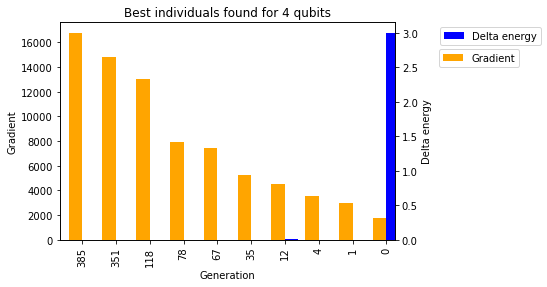

In [272]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
test = experiment_best_individual_graph_data

df = pd.DataFrame(test, columns=["Generations", "Gradient", "Delta energy"])
# ax = df.plot(x="A", y=["B","C"], kind="bar", rot=0)
# _ = ax.legend(bbox_to_anchor=(1, 1.02), loc='upper left')

fig = plt.figure()
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx()
width = 0.4
df.iloc[:,2].plot(kind='bar', color='blue', ax=ax2, width=width, position=0)
df.iloc[:,1].plot(kind='bar', color='orange', ax=ax, width=width, position=1)

ax2.set_ylabel('Delta energy')
ax.set_ylabel('Gradient')
ax2.legend(loc='upper right', bbox_to_anchor=(1.45, 1))
ax.legend(loc='upper right', bbox_to_anchor=(1.385, 0.9))

ax.set_title("Best individuals found for 4 qubits")
ax.set_xticklabels(df.iloc[:,0], rotation=90)
ax.set_xlabel("Generation")
fig.savefig("energy4qubitbestindivgradient.png",dpi=300, bbox_inches="tight", facecolor='white')
plt.show()

In [48]:
# [final_population,total runtime, data_average_fitness each 50 generations, data_average_crowd_score each 50 generations, data_best_individual, data_best_family]
from HelperCLQGA import genome_to_circuit
from qiskit.circuit import QuantumCircuit
import matplotlib.pyplot as plt

circuit_figures = []
for i in range(0,len(experiment_best_individual)):
    for best_circuit in experiment_best_individual[i][5]:
        
        if type(best_circuit) == QuantumCircuit:
            circuit_figures.append(best_circuit.draw(output='mpl', idle_wires=False))
print(experiment_evolution)

[[[73, 23], [89.2, 34.7]], [[116, 39], [76.6, 25.1]], [[33, 8], [74.3, 26.7]], [[138, 52], [108.1, 42.9]], [[121, 51], [106.0, 42.7]], [[104, 39], [93.2, 39.2]], [[55, 20], [96.2, 35.8]], [[166, 75], [95.6, 32.6]], [[93, 36], [71.8, 23.7]], [[27, 3], [92.2, 33.4]], [[70, 16], [81.1, 25.1]], [[106, 45], [90.8, 31.5]], [[33, 4], [82.7, 29.4]], [[152, 63], [72.9, 20.8]], [[71, 26], [65.5, 22.3]], [[41, 13], [62.8, 17.0]], [[47, 22], [66.0, 22.5]], [[47, 11], [65.0, 18.9]], [[50, 10], [70.8, 19.8]], [[76, 26], [63.9, 18.4]], [[94, 37], [98.6, 36.3]], [[45, 8], [66.4, 19.7]], [[69, 22], [68.0, 19.9]], [[59, 16], [74.4, 24.9]], [[47, 18], [78.1, 28.6]], [[30, 2], [53.2, 14.1]], [[55, 19], [59.0, 19.9]], [[49, 13], [58.1, 20.8]], [[50, 17], [58.6, 16.9]], [[43, 12], [68.6, 21.3]], [[28, 3], [57.3, 17.0]], [[97, 35], [58.5, 17.4]], [[63, 27], [76.3, 27.2]], [[58, 15], [63.8, 18.8]], [[115, 41], [88.0, 31.8]], [[143, 65], [84.1, 30.9]], [[133, 61], [73.5, 24.6]], [[94, 18], [73.8, 22.0]], [[81,

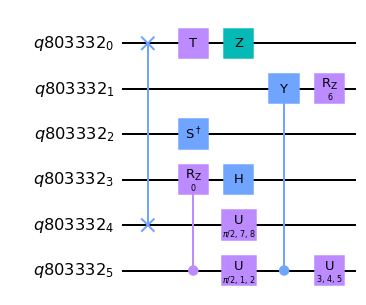

In [49]:
# circuit_figures[0]
genome_to_circuit(experiment_population[3].chromosome, 6, 20)[0].draw(output='mpl', idle_wires=False)

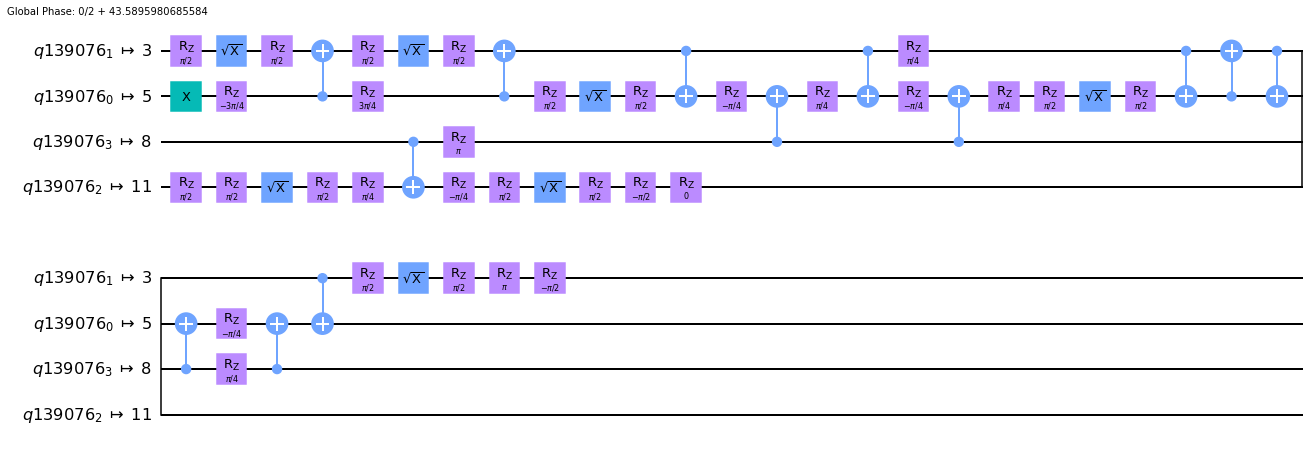

In [44]:
circuit_figures[-1]